# Hardbrücke 

## Quelle

https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Get Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

In [ ]:
os.listdir('/content/gdrive/MyDrive/ColabNotebooks/hardbruecke')

['frequenzen_hardbruecke_2020.zip', 'hardbruecke.ipynb']

In [ ]:
filepath = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/frequenzen_hardbruecke_2020.zip'

In [ ]:
hb = pd.read_csv(filepath,compression='zip')

In [ ]:
hb['Timestamp'] = pd.to_datetime(hb['Timestamp'])

In [ ]:
hb.head()

,In,Out,Timestamp,Name
0,1,0,2020-01-01 23:55:00,Ost-Nord total
1,2,5,2020-01-01 23:50:00,Ost-Nord total
2,1,0,2020-01-01 23:45:00,Ost-Nord total
3,1,4,2020-01-01 23:40:00,Ost-Nord total
4,1,0,2020-01-01 23:35:00,Ost-Nord total


In [ ]:
hb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714681 entries, 0 to 714680
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   In         714681 non-null  int64         
 1   Out        714681 non-null  int64         
 2   Timestamp  714681 non-null  datetime64[ns]
 3   Name       714681 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 21.8+ MB


In [ ]:
hb.describe()

,In,Out
count,714681.000000,714681.000000
mean,12.405247,10.299464
std,16.061613,12.936968
min,0.000000,0.000000
25%,3.000000,2.000000
50%,7.000000,6.000000
75%,16.000000,13.000000
max,253.000000,276.000000


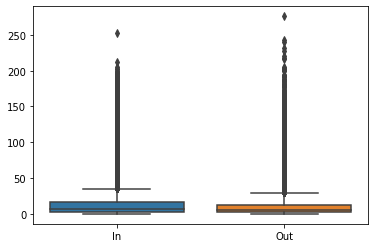

In [ ]:
sns.boxplot(data=hb[['In','Out']])

In [ ]:
hb2 = hb.set_index(['Timestamp','Name']).stack().reset_index()

In [ ]:
hb2.head()

,Timestamp,Name,level_2,0
0,2020-01-01 23:55:00,Ost-Nord total,In,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0
2,2020-01-01 23:50:00,Ost-Nord total,In,2
3,2020-01-01 23:50:00,Ost-Nord total,Out,5
4,2020-01-01 23:45:00,Ost-Nord total,In,1


## Data preparation

In [ ]:
hb2 = hb2.rename(columns={'level_2':'direction',0:'count'})

In [ ]:
hb2.head()

,Timestamp,Name,direction,count
0,2020-01-01 23:55:00,Ost-Nord total,In,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0
2,2020-01-01 23:50:00,Ost-Nord total,In,2
3,2020-01-01 23:50:00,Ost-Nord total,Out,5
4,2020-01-01 23:45:00,Ost-Nord total,In,1


In [ ]:
hb2['hour'] = hb2['Timestamp'].dt.hour
hb2['weekday'] = hb2['Timestamp'].dt.weekday
hb2['minute'] = hb2['Timestamp'].dt.minute
hb2['month'] = hb2['Timestamp'].dt.month

In [ ]:
hb2['direction_cat'] = hb2['direction'].replace({'In':0,'Out':1})

In [ ]:
names = {
    'Ost-Süd total' : 0,
    'Ost-Nord total' : 1,
    'Ost-SBB total' : 2,
    'West-SBB total' : 3,
    'West-Süd total' : 4,
    'Ost-VBZ Total' : 5,
    'West-Nord total' : 6,
    'West-VBZ total' : 7,
}
hb2['name_cat'] = hb2['Name'].replace(names)

In [ ]:
hb2

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1429357,2020-12-31 00:15:00,West-VBZ total,Out,4,0,3,15,12,1,7
1429358,2020-12-31 00:10:00,West-VBZ total,In,3,0,3,10,12,0,7
1429359,2020-12-31 00:10:00,West-VBZ total,Out,5,0,3,10,12,1,7
1429360,2020-12-31 00:05:00,West-VBZ total,In,4,0,3,5,12,0,7


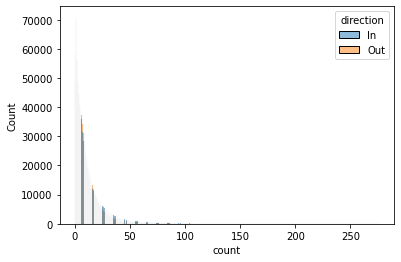

In [ ]:
sns.histplot(data=hb2,x='count',hue='direction')

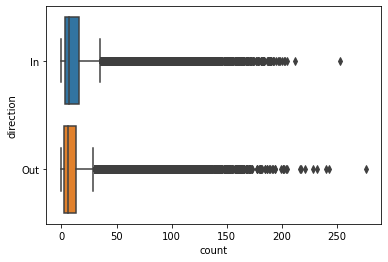

In [ ]:
sns.boxplot(data=hb2,x='count',y='direction')

In [ ]:
hb2['Name'].value_counts()

Ost-Süd total      188858
Ost-Nord total     184822
Ost-SBB total      181088
West-SBB total     180502
West-Süd total     178876
Ost-VBZ Total      174570
West-Nord total    171872
West-VBZ total     168774
Name: Name, dtype: int64

In [ ]:
hb2['direction'].value_counts()

Out    714681
In     714681
Name: direction, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

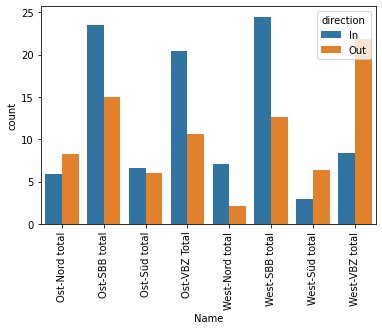

In [ ]:
name = hb2.groupby(['Name','direction'])['count'].mean()
sns.barplot(data=name.reset_index(),x='Name',y='count',hue='direction')
plt.xticks(rotation = 90)

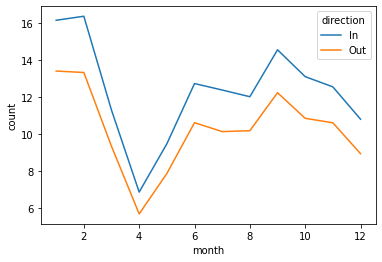

In [ ]:
months = hb2.groupby(['month','direction'])['count'].mean()
sns.lineplot(data=months.reset_index(),x='month',y='count',hue='direction')

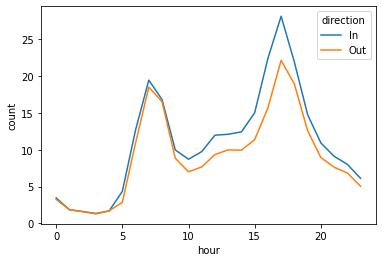

In [ ]:
hour = hb2.groupby(['hour','direction'])['count'].mean()
sns.lineplot(data=hour.reset_index(),x='hour',y='count',hue='direction')

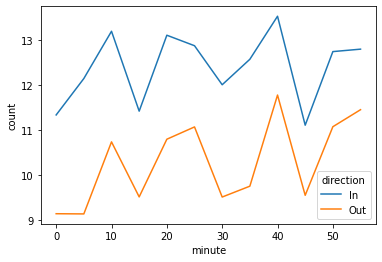

In [ ]:
minute = hb2.groupby(['minute','direction'])['count'].mean()
sns.lineplot(data=minute.reset_index(),x='minute',y='count',hue='direction')

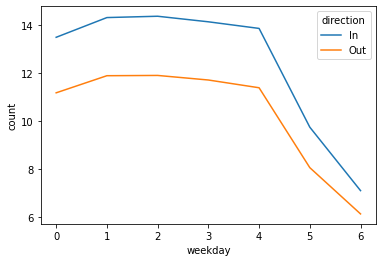

In [ ]:
weekday = hb2.groupby(['weekday','direction'])['count'].mean()
sns.lineplot(data=weekday.reset_index(),x='weekday',y='count',hue='direction')

In [ ]:
hb2.head()

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1


# Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics 

In [ ]:
hb2.head()

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1


In [ ]:
hb2.groupby(['hour'])['count'].sum()

hour
0      181436
1       57606
2       34162
3       24404
4       45373
5      165184
6      751948
7     1245079
8     1127431
9      646635
10     544232
11     603950
12     741396
13     768090
14     777419
15     918817
16    1327327
17    1753447
18    1423607
19     952249
20     690066
21     577319
22     507321
23     362127
Name: count, dtype: int64

In [ ]:
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
]
y='count'

In [ ]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

## Decicion Tree

In [ ]:
regressor = DecisionTreeRegressor(max_depth=15)  
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
import pickle

In [ ]:
filename = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/DecisionTreeRegressor.sav'
pickle.dump(regressor, open(filename, 'wb'))

In [ ]:
regressor = pickle.load(open(filename, 'rb'))

Die anderen Modelle performen fast identisch. Einfache Transformationen haben nichts gebracht. Die Performance ist nicht optimal aber für einen ersten Test gut genug.

Möglicherweise würden einige Zusatzinformationen noch etwas bringen. Z.B. Lockdown relevante Informationen, oder ein Feiertagskalender. Auch die Pünktlichkeitsdaten (bzw. der Fahrplan) könnten helfen.
-> Komplexität der Implementierung sollte geprüft werden

In [ ]:
y_pred = regressor.predict(X_test) 

In [ ]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  
df.head(20)

,Actual,Predicted
21550,5,6.068702
939102,11,13.948718
598313,18,8.669697
1190481,11,8.125000
533498,4,7.142857
745756,2,8.884021
607591,4,13.587601
1397093,26,17.310517
1226828,3,2.641641
397012,8,7.473684


In [ ]:
importance = regressor.feature_importances_
importance_df = pd.DataFrame(importance, index=X_train.columns, 
                      columns=["Importance"])
importance_df

,Importance
hour,0.368319
weekday,0.094696
minute,0.043525
month,0.120148
direction_cat,0.111801
name_cat,0.261511


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.428023041012632
Mean Squared Error: 57.67538931051158
Root Mean Squared Error: 7.594431467233843


(0.0, 240.0, -10.0, 210.0)

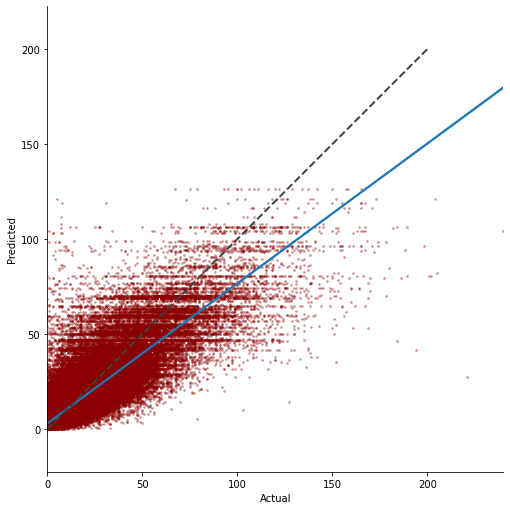

In [ ]:
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=True,scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')


## Radom Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=30,n_jobs=-1,max_depth=20) 
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)


Mean Absolute Error: 4.41938015716363
Mean Squared Error: 57.39614904325798
Root Mean Squared Error: 7.57602462002718


## Linear Regression

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.41938015716363
Mean Squared Error: 57.39614904325798
Root Mean Squared Error: 7.57602462002718


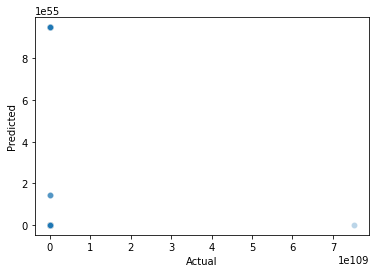

In [ ]:
sns.scatterplot(data=df,y='Predicted',x='Actual',alpha=0.3)

## lightgbm

In [ ]:
import lightgbm as lgb

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

https://lightgbm.readthedocs.io/en/latest/

Ausserdem können hier kategoriale Variablen explizit berücksichtigt werden.

In [ ]:
# kategorielle Variablen
categorical_features = ['direction_cat','name_cat','weekday']
# alle Variablen
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
]
y='count'

#### Training

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train
 ,feature_name = XList
 , categorical_feature = categorical_features
)

In [ ]:
params = {
 'task': 'train' 
 #, 'boosting_type': 'dart'
 #, 'max_depth' : 25
 , 'objective': 'regression' 
 #, 'num_leaves':60
 #, 'num_class': num_of_classes
 , 'metric': 'mse' #'mae' #'rmsle' 
 #,'min_data_in_leaf': 40
 #,'num_trees':100 # default 100
 #, 'min_data': 5
 #, 'verbose': -1
}
gbm = lgb.train(params, lgb_train)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.



#### Prognose

In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  
df.tail()

,Actual,Predicted
225531,12,11.939739
1268237,0,4.377862
267281,35,29.960621
1184014,2,6.114200
760273,2,2.945682


#### Validierung

(0.0, 240.0, -12.889564149606926, 210.13759829283842)

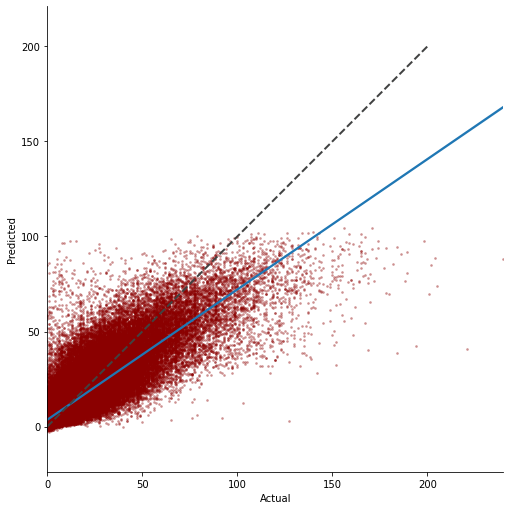

In [ ]:
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=True,scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')


In [ ]:
#sns.jointplot(x='Actual', y='Predicted', kind="reg", data=df)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred) )
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score: ',metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 4.651438025184883
Mean Squared Error: 60.07953369908116
Root Mean Squared Error: 7.7510988704235455
R2 Score:  0.7212215256984164


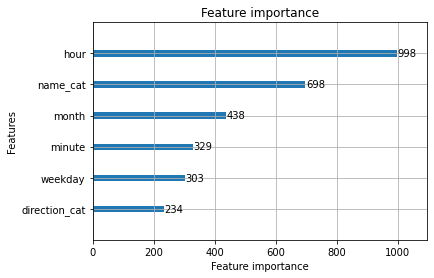

In [ ]:
ax = lgb.plot_importance(gbm,)
plt.show()

# Log Transform

In [ ]:
hb2['count_log'] = np.log(hb2['count']+1)

In [ ]:
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
]
y='count_log'

In [ ]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

## Decicion Tree

In [ ]:
regressor = DecisionTreeRegressor(max_depth=15)  
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = regressor.predict(X_test) 

In [ ]:
df=pd.DataFrame({'Actual':np.exp(y_test)-1, 'Predicted':np.exp(y_pred)-1})  
df.head(20)

,Actual,Predicted
220845,13.0,10.478126
116990,2.0,3.278223
992814,25.0,24.705665
1062867,2.0,1.715174
1176740,1.0,0.404470
723486,17.0,22.010064
290480,35.0,27.617288
806006,10.0,7.813056
901952,28.0,41.610854
384508,19.0,11.701323


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 0.43173281651268436
Mean Squared Error: 0.3154181389753173
Root Mean Squared Error: 0.5616209922851151


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Mean Squared Error:', metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.453969252728549
Mean Squared Error: 63.28957357746446
Root Mean Squared Error: 7.9554744407523845


## Radom Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=30,n_jobs=-1,max_depth=20) 
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)


Mean Absolute Error: 0.43173281651268436
Mean Squared Error: 0.3154181389753173
Root Mean Squared Error: 0.5616209922851151


## Linear Regression

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 0.43173281651268436
Mean Squared Error: 0.3154181389753173
Root Mean Squared Error: 0.5616209922851151


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Mean Squared Error:', metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.453969252728549
Mean Squared Error: 63.28957357746446
Root Mean Squared Error: 7.9554744407523845


# Try Dummies

In [ ]:
dummies = pd.get_dummies(hb2['Name'])
dummy_cols = dummies.columns

In [ ]:
hb2 = pd.concat([hb2,dummies],axis=1)
hb2.head()

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat,count_log,Ost-Nord total,Ost-SBB total,Ost-Süd total,Ost-VBZ Total,West-Nord total,West-SBB total,West-Süd total,West-VBZ total
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1,0.693147,1,0,0,0,0,0,0,0
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1,0.000000,1,0,0,0,0,0,0,0
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1,1.098612,1,0,0,0,0,0,0,0
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1,1.791759,1,0,0,0,0,0,0,0
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1,0.693147,1,0,0,0,0,0,0,0


In [ ]:
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  #'name_cat',
] + dummy_cols.to_list()
y='count'

In [ ]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

## Decision Tree

In [ ]:
regressor = DecisionTreeRegressor(max_depth=15)  
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = regressor.predict(X_test) 

In [ ]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  
df.head(20)

,Actual,Predicted
3242,16,12.859604
30709,20,14.608475
978722,33,26.896552
294199,7,7.666667
1286101,6,18.000000
765296,2,2.138047
48801,14,13.918539
657163,11,22.545455
537019,1,4.806841
379730,6,5.604502


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.506440658037878
Mean Squared Error: 58.11544660857731
Root Mean Squared Error: 7.623348779150624


## Radom Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=30,n_jobs=-1,max_depth=20) 
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)


Mean Absolute Error: 4.506440658037878
Mean Squared Error: 58.11544660857731
Root Mean Squared Error: 7.623348779150624


## Linear Regression

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.506440658037878
Mean Squared Error: 58.11544660857731
Root Mean Squared Error: 7.623348779150624


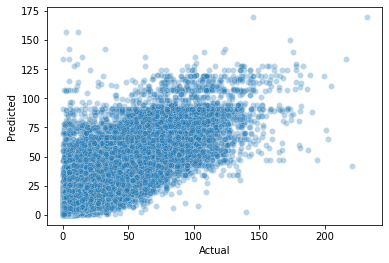

In [ ]:
sns.scatterplot(data=df,y='Predicted',x='Actual',alpha=0.3)